In [2]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc

In [3]:
matplotlib.rcParams['figure.dpi'] = 120

In [4]:
def spark_start(project_path, metastore=None, local_dir=None):
    from pyspark.sql import SparkSession

    warehouse_location = project_path #os.path.join(project_path, 'spark-warehouse')

    if local_dir is None:
        local_dir = os.path.join(project_path, 'spark-tmp')

    spark = ( 
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", warehouse_location)
            .config('spark.master', "local[6]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={metastore}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/data/", local_dir="/epyc/users/ecbellm")

#catalog = axs.AxsCatalog(spark_session)

In [5]:
spark_session

In [6]:
catalog = axs.AxsCatalog(spark_session)

In [7]:
catalog.list_tables().keys()

dict_keys(['sdss_zoned1am_hd', 'gaia_zoned1am_hd', 'gaia_dr2_1am_dup', 'sdss_zoned1am_700lc', 'gaia_dr2_700lc2', 'allwise_1am_dup', 'gaia_sdss_wise_1asec', 'gaia_sdss_3asec', 'ztf_1am_old', 'ztf_exposures', 'ztf_1am_lc', 'ztf_1am', 'ztf_1am_test', 'sesar_rrlyrae', 'ztf_fid1_sdss_stars_lt20_2asec', 'ztf_fid2_sdss_stars_lt20_2asec', 'ztf_fid3_sdss_stars_lt20_2asec', 'sdss_dr9_qso_s82', 'ztf_sdss_dr9_qso', 'faraway_training_dataset', 'faraway_labeled_training_dataset', 'ztf_nobs100', 'jnk_ztf_test', 'jnk_ztf_test2', 'ztf1000', 'ztf_sdss_dr9_qso2', 'ztf10', 'ztf_dec18', 'asassn_variability_catalog', 'ztf10_assasn', 'ztf10_assasn_cesium', 'ztf10_assasn_best', 'ztf10_assasn_cesium_best', 'unwise_v1', 'cklein_flare', 'unwise_v2', 'cesium_speedtest_ztfsample'])

In [8]:
%%time
ztf = catalog.load("ztf_dec18")

CPU times: user 7.14 ms, sys: 11.2 ms, total: 18.4 ms
Wall time: 10.8 s


In [20]:
ztf.columns

['matchid',
 'ra',
 'dec',
 'nobs_avail',
 'combined_matchids',
 'mjd',
 'programid',
 'filterid',
 'mag',
 'magerr',
 'psfmag',
 'psfmagerr',
 'psfflux',
 'psffluxerr',
 'chi',
 'catflags',
 'sharp',
 'xpos',
 'ypos',
 'zone',
 'dup']

In [10]:
%%time
radec = ztf.region(ra1=0, ra2=1, dec1=0, dec2=1).select("ra", "dec").toPandas()

CPU times: user 26.3 ms, sys: 30.3 ms, total: 56.6 ms
Wall time: 22.9 s


In [11]:
%%time
radec = ztf.cone(ra=287.9869104, dec=13.0748496, r=10/3600.).select("ra", "dec").toPandas()

CPU times: user 158 ms, sys: 81.5 ms, total: 240 ms
Wall time: 12min 23s


In [14]:
%%time
testra = 287.9869104
testdec = 13.0748496
d = 10/3600.
radec = ztf.region(ra1=testra-d, ra2=testra+d, dec1=testdec-d, dec2=testdec+d).select("ra", "dec").toPandas()


CPU times: user 16.5 ms, sys: 7.26 ms, total: 23.7 ms
Wall time: 5.1 s


In [15]:
len(radec)

8

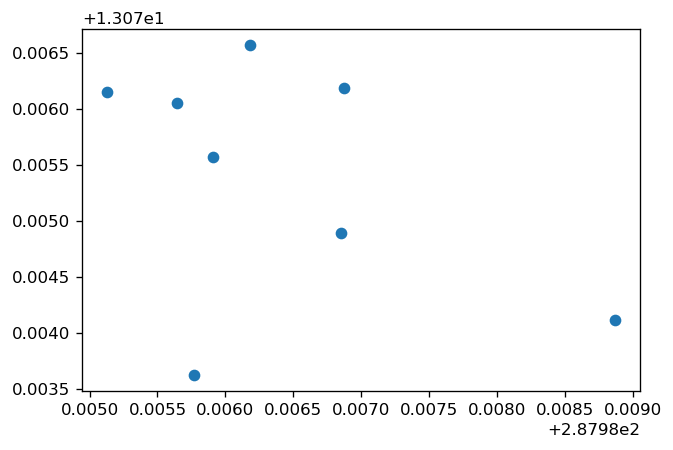

In [17]:
plt.plot(radec['ra'], radec['dec'], 'o')

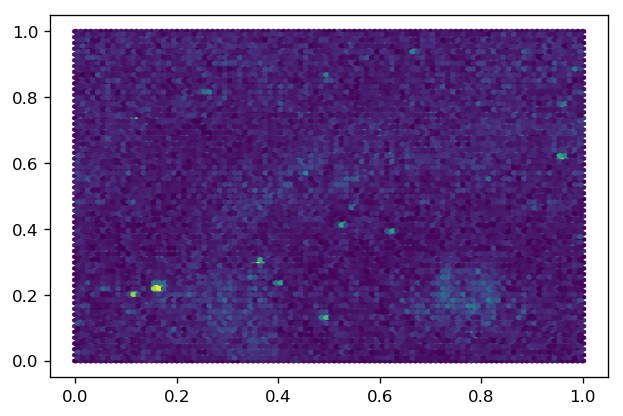

In [15]:
plt.hexbin(radec['ra'], radec['dec'])

In [18]:
gaia = catalog.load("gaia_dr2_1am_dup")

In [19]:
gaia.columns

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

In [23]:
%%time
gaia_match = ztf.region(ra1=testra-d, ra2=testra+d, dec1=testdec-d, dec2=testdec+d).crossmatch(gaia).select("combined_matchids","bp_rp", "phot_g_mean_mag", "phot_g_mean_flux_over_error", "parallax", "parallax_error").toPandas()

CPU times: user 27.1 ms, sys: 11.9 ms, total: 39 ms
Wall time: 1min 15s


In [27]:
gaia_match.combined_matchids

0    [539091210021486, 539091210021486, 53909121002...
1    [539091200169560, 539091200169560, 53909120016...
2    [539091200144433, 539091200144433, 53909120014...
3    [539091200095877, 539091200095877, 53909120009...
4    [539091200095931, 539091200095931, 53909120009...
5    [539091200022594, 539091200022594, 53909120002...
6    [539091200022594, 539091200022594, 53909120002...
Name: combined_matchids, dtype: object

In [28]:
gaia_match

,combined_matchids,bp_rp,phot_g_mean_mag,phot_g_mean_flux_over_error,parallax,parallax_error
0,"[539091210021486, 539091210021486, 53909121002...",NaN,21.252653,26.392502,NaN,NaN
1,"[539091200169560, 539091200169560, 53909120016...",1.962526,20.610218,136.230728,1.294866,1.226691
2,"[539091200144433, 539091200144433, 53909120014...",NaN,21.399178,32.201534,NaN,NaN
3,"[539091200095877, 539091200095877, 53909120009...",1.894012,20.256207,192.555542,-0.059701,0.735873
4,"[539091200095931, 539091200095931, 53909120009...",2.932623,19.596601,291.541779,0.867655,0.563483
5,"[539091200022594, 539091200022594, 53909120002...",2.656782,20.182062,183.464554,0.272276,0.933420
6,"[539091200022594, 539091200022594, 53909120002...",NaN,20.916426,68.139877,NaN,NaN
